# 2.2 IP102 Dataset (Pest Classification)

This notebook demonstrates pest classification using the **IP102** dataset:

- **Source:** IP102-dataset  
- **Size:** ~75,000 images  
- **Classes:** 102 pest categories  
- **Format:** RGB images captured in real field conditions, with high variance in lighting, angle, and pest visibility.

> **Note:** The dataset is heavily imbalanced—some classes have fewer than 10 labeled samples, while others have several hundred.

## 💡 Techniques Used

- **Class weight balancing** in the loss function
- **Image augmentation** to replicate underrepresented classes
- **Focal Loss** to improve learning on hard examples and minority classes
- **Transfer learning** with EfficientNetB3 for better feature extraction

Despite the imbalance, the model achieved **~60%+ accuracy**, providing a strong baseline for this challenging, large-scale multiclass problem.

## 📌 Phase 1: Data Cleaning & Inspection

Before building the pest classification model, we begin by inspecting and preparing the IP102 dataset:

- **Root paths** for the dataset and its splits are defined for easy access.
- **Class mapping** is loaded from `classes.txt` to identify all pest categories.
- A **preview of class labels** is printed to verify the mapping.
- **Quick checks** on the `train.txt`, `val.txt`, and `test.txt` files ensure the splits are correctly structured and accessible.

This initial inspection step helps confirm the integrity and organization of the dataset before proceeding to further cleaning and

In [ ]:
# 📌 Phase: Data Cleaning & Inspection
# 🐛 IP102 - Pest Classification Dataset

from pathlib import Path

# ✅ Define root paths
DATASET_DIR = Path('/kaggle/input/ip02-dataset')
CLASSIFICATION_DIR = DATASET_DIR / "classification"
CLASSES_TXT = DATASET_DIR / "classes.txt"
TRAIN_TXT = DATASET_DIR / "train.txt"
VAL_TXT = DATASET_DIR / "val.txt"
TEST_TXT = DATASET_DIR / "test.txt"

# ✅ Read class mapping
with open(CLASSES_TXT, "r") as f:
    classes = [line.strip() for line in f.readlines()]

print(f"🧬 Total classes: {len(classes)} pest categories found.")
print("🔖 Preview of class labels:")
for i, name in enumerate(classes[:5]):
    print(f"   [{i}] {name}")
if len(classes) > 5:
    print("   ...")

# ✅ Quick check of split files
def preview_split(split_path, label):
    print(f"\n📁 Preview of {label}.txt:")
    with open(split_path, "r") as f:
        for _ in range(5):
            print("   └─", f.readline().strip())

preview_split(TRAIN_TXT, "train")
preview_split(VAL_TXT, "val")
preview_split(TEST_TXT, "test")


🧬 Total classes: 102 pest categories found.
🔖 Preview of class labels:
   [0] 1  rice leaf roller
   [1] 2  rice leaf caterpillar
   [2] 3  paddy stem maggot
   [3] 4  asiatic rice borer
   [4] 5  yellow rice borer
   ...

📁 Preview of train.txt:
   └─ 00002.jpg 0
   └─ 00003.jpg 0
   └─ 00005.jpg 0
   └─ 00006.jpg 0
   └─ 00008.jpg 0

📁 Preview of val.txt:
   └─ 00009.jpg 0
   └─ 00012.jpg 0
   └─ 00014.jpg 0
   └─ 00034.jpg 0
   └─ 00035.jpg 0

📁 Preview of test.txt:
   └─ 00000.jpg 0
   └─ 00001.jpg 0
   └─ 00004.jpg 0
   └─ 00007.jpg 0
   └─ 00010.jpg 0


### 🧼 Cleaning Class Names

The original `classes.txt` file contains class names prefixed by numeric IDs. For clarity and usability, we remove these leading IDs to obtain clean pest category names.

- **Regular expressions** are used to strip numeric prefixes from each class entry.
- The cleaned class names are previewed to verify correctness.
- An assertion ensures that the number of cleaned classes matches the expected 102 categories.

This step ensures that class labels are human-readable and ready for further analysis and

In [ ]:
# ✅ Clean class names: remove leading ID in 'classes.txt'
import re

cleaned_classes = []
for entry in classes:
    match = re.match(r"\d+\s+(.*)", entry)
    if match:
        cleaned_classes.append(match.group(1))
    else:
        cleaned_classes.append(entry)  # fallback

# ✅ Preview cleaned names
print("🧼 Cleaned class names:")
for i, name in enumerate(cleaned_classes[:5]):
    print(f"   [{i}] {name}")
if len(cleaned_classes) > 5:
    print("   ...")

# ✅ Confirm count match
assert len(cleaned_classes) == 102, "Mismatch in class count!"


🧼 Cleaned class names:
   [0] rice leaf roller
   [1] rice leaf caterpillar
   [2] paddy stem maggot
   [3] asiatic rice borer
   [4] yellow rice borer
   ...


In [ ]:
import pandas as pd
from pathlib import Path

pd.set_option('display.max_rows', None)

# Set path
train_dir = Path('/kaggle/input/ip02-dataset/classification/train')

# Count images per class
train_counts = []
for class_dir in sorted(train_dir.iterdir()):
    if class_dir.is_dir():
        count = len(list(class_dir.glob('*.jpg')))
        train_counts.append({'class_id': class_dir.name, 'image_count': count})

df_train = pd.DataFrame(train_counts)
df_train = df_train.sort_values('class_id').reset_index(drop=True)
print("📊 Train Split Class Distribution (All 102 Classes):")
display(df_train)


📊 Train Split Class Distribution (All 102 Classes):


,class_id,image_count
0,0,669
1,1,292
2,10,513
3,100,274
4,101,3444
5,11,242
6,12,103
7,13,245
8,14,516
9,15,989


In [ ]:
val_dir = Path('/kaggle/input/ip02-dataset/classification/val')

val_counts = []
for class_dir in sorted(val_dir.iterdir()):
    if class_dir.is_dir():
        count = len(list(class_dir.glob('*.jpg')))
        val_counts.append({'class_id': class_dir.name, 'image_count': count})

df_val = pd.DataFrame(val_counts)
df_val = df_val.sort_values('class_id').reset_index(drop=True)
print("📊 Val Split Class Distribution (All 102 Classes):")
pd.set_option('display.max_rows', None)
display(df_val)


📊 Val Split Class Distribution (All 102 Classes):


,class_id,image_count
0,0,111
1,1,48
2,10,86
3,100,46
4,101,573
5,11,40
6,12,18
7,13,41
8,14,86
9,15,165


In [ ]:
test_dir = Path('/kaggle/input/ip02-dataset/classification/test')

test_counts = []
for class_dir in sorted(test_dir.iterdir()):
    if class_dir.is_dir():
        count = len(list(class_dir.glob('*.jpg')))
        test_counts.append({'class_id': class_dir.name, 'image_count': count})

df_test = pd.DataFrame(test_counts)
df_test = df_test.sort_values('class_id').reset_index(drop=True)
print("📊 Test Split Class Distribution (All 102 Classes):")
pd.set_option('display.max_rows', None)
display(df_test)


📊 Test Split Class Distribution (All 102 Classes):


,class_id,image_count
0,0,335
1,1,147
2,10,257
3,100,138
4,101,1723
5,11,122
6,12,52
7,13,123
8,14,258
9,15,495


### 📦 Dataset Split Summary

To understand the scale and structure of the IP102 dataset, we count the total number of images in each split (`train`, `val`, and `test`). This provides a quick overview of the dataset distribution and helps verify that the splits are correctly organized.

- **Train split:** Used for model training.
- **Validation split:** Used for tuning hyperparameters and monitoring overfitting.
- **Test split:** Used for final evaluation of model performance.

The resulting table shows the image count for each split, confirming the dataset's integrity and readiness for further processing.

In [ ]:
from pathlib import Path

# Define folder paths
base_path = Path('/kaggle/input/ip02-dataset/classification')
splits = ['train', 'val', 'test']

# Count images in each split
split_counts = []
for split in splits:
    split_path = base_path / split
    total_images = len(list(split_path.glob('*/*.jpg')))
    split_counts.append({'split': split, 'image_count': total_images})

# Display result
import pandas as pd
df_split_counts = pd.DataFrame(split_counts)
print("📦 Image Count in Each Dataset Split:")
display(df_split_counts)


📦 Image Count in Each Dataset Split:


,split,image_count
0,train,45095
1,val,7508
2,test,22619


### 🖼️ Image Dimension Analysis & Visual Inspection

To better understand the diversity and quality of the IP102 dataset images, we perform two key exploratory steps:

- **Image Dimension Distribution:**  
  We analyze the width and height of a sample of images from each class in the training split. This helps visualize the range and frequency of image sizes, which is important for preprocessing and model input consistency.

- **Random Sample Visualization:**  
  We display a few random images from the training set, along with their class IDs and dimensions. This provides a quick visual check of the dataset's variety, image quality, and labeling.

These steps ensure that the dataset is suitable for deep learning workflows and help identify any potential issues with image sizes or class organization before model

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128208 (\N{TRIANGULAR RULER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


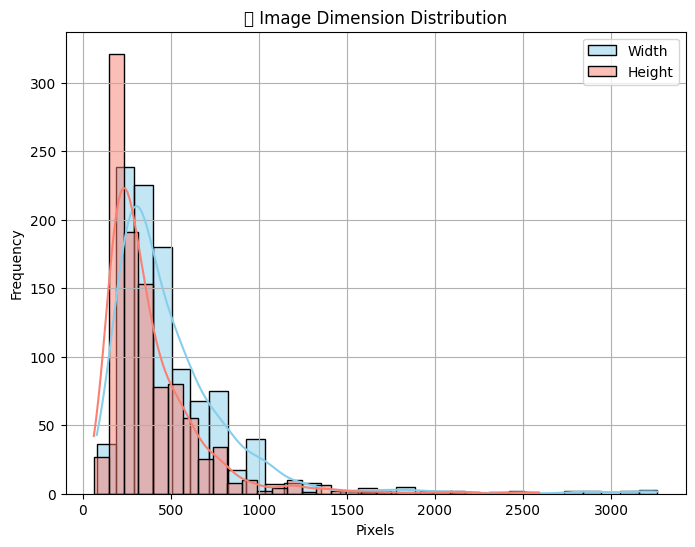

📁 Class ID: 58 | 🖼️ Image: 41985.jpg | Size: (297, 167)


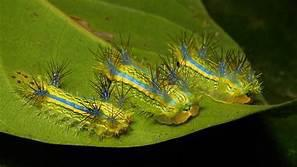

📁 Class ID: 57 | 🖼️ Image: 40720.jpg | Size: (359, 268)


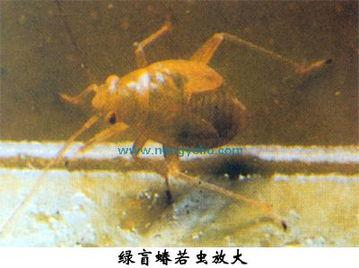

📁 Class ID: 74 | 🖼️ Image: 58766.jpg | Size: (276, 213)


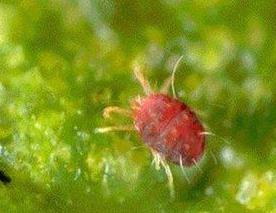

📁 Class ID: 96 | 🖼️ Image: 68048.jpg | Size: (220, 147)


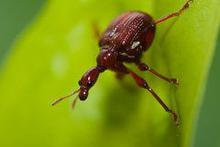

📁 Class ID: 84 | 🖼️ Image: 62478.jpg | Size: (550, 397)


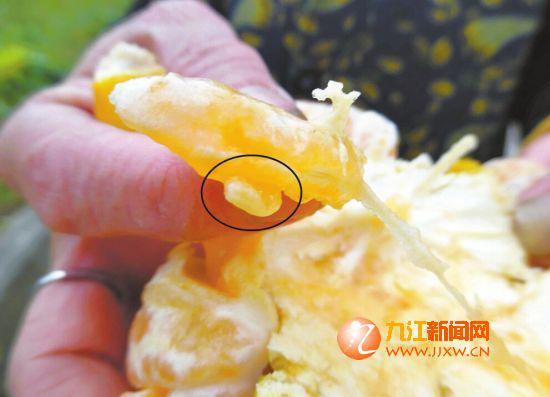

In [ ]:
import random
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

# Set your dataset path
DATASET_DIR = Path('/kaggle/input/ip02-dataset')
CLASSIFICATION_DIR = DATASET_DIR / 'classification'

# Show image size distribution (train split)
train_path = CLASSIFICATION_DIR / 'train'
img_shapes = []

for class_folder in train_path.iterdir():
    if class_folder.is_dir():
        for img_path in list(class_folder.glob('*.jpg'))[:10]:  # only first 10 per class
            try:
                img = Image.open(img_path)
                img_shapes.append(img.size)
            except:
                pass

# Convert to DataFrame
img_shapes_df = pd.DataFrame(img_shapes, columns=['Width', 'Height'])

# Plot image size distribution
plt.figure(figsize=(8, 6))
sns.histplot(data=img_shapes_df, x='Width', bins=30, color='skyblue', label='Width', kde=True)
sns.histplot(data=img_shapes_df, x='Height', bins=30, color='salmon', label='Height', kde=True)
plt.legend()
plt.title('📐 Image Dimension Distribution')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Show random image samples
def show_samples(split='train', n=5):
    split_dir = CLASSIFICATION_DIR / split
    class_dirs = list(split_dir.iterdir())
    samples = []

    while len(samples) < n:
        class_dir = random.choice(class_dirs)
        imgs = list(class_dir.glob('*.jpg'))
        if imgs:
            samples.append(random.choice(imgs))

    for img_path in samples:
        try:
            img = Image.open(img_path)
            print(f"📁 Class ID: {img_path.parent.name} | 🖼️ Image: {img_path.name} | Size: {img.size}")
            display(img)
        except:
            continue

# Show 5 random train images
show_samples('train', 5)


In [ ]:
# 🐛 Load class names
classes_path = '/kaggle/input/ip02-dataset/classes.txt'

with open(classes_path, 'r') as f:
    class_names = [line.strip() for line in f.readlines()]

# 🪲 Show all 102 class names with their IDs
import pandas as pd

df_classes = pd.DataFrame({
    'class_id': list(range(len(class_names))),
    'pest_name': class_names
})

pd.set_option('display.max_rows', None)
print("📖 Pest Class Mapping (ID → Name):")
display(df_classes)


📖 Pest Class Mapping (ID → Name):


,class_id,pest_name
0,0,1 rice leaf roller
1,1,2 rice leaf caterpillar
2,2,3 paddy stem maggot
3,3,4 asiatic rice borer
4,4,5 yellow rice borer
5,5,6 rice gall midge
6,6,7 Rice Stemfly
7,7,8 brown plant hopper
8,8,9 white backed plant hopper
9,9,10 small brown plant hopper


### ⚖️ Class Weight Calculation

The IP102 dataset is highly imbalanced, with some pest categories having far fewer images than others. To address this, we compute **class weights** that will be used during model training:

- The number of images per class is expanded into a label array.
- `compute_class_weight` from scikit-learn calculates balanced weights for each class.
- These weights help the model pay more attention to underrepresented classes, improving overall performance and fairness.

This step is crucial for robust training on imbalanced

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get expanded label list
labels = df_train['class_id'].astype(int)
counts = df_train['image_count']
expanded_labels = np.repeat(labels, counts)

# Compute weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=expanded_labels
)

class_weight_dict = dict(enumerate(class_weights))

print("✅ Class weights ready to be used during training.")


✅ Class weights ready to be used during training.


### 🧬 Data Augmentation for Class Balancing

To address the severe class imbalance in the IP102 dataset, we use **image augmentation** to increase the number of samples for underrepresented classes:

- For each class with fewer than 400 images, new images are generated using random transformations (rotation, zoom, shift, brightness, and flip).
- The original images are copied, and augmented images are saved to a new directory, ensuring each class has at least 400 samples.
- This process helps the model generalize better and reduces bias toward majority classes.

Augmentation is a crucial step for improving model robustness and fairness in imbalanced datasets.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from pathlib import Path
from tqdm import tqdm
import numpy as np

# Set this again here
AUG_THRESHOLD = 400

# Directories
orig_train_dir = Path("/kaggle/input/ip02-dataset/classification/train")
aug_train_dir = Path("/kaggle/working/ip02_augmented")
aug_train_dir.mkdir(parents=True, exist_ok=True)

# Augmentor (for saving extra images to disk)
augmentor = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode="nearest"
)

# Save original + augmented images
print("🚀 Copying & augmenting underrepresented classes...")
for row in tqdm(df_train.itertuples(), total=len(df_train)):
    class_id = str(row.class_id)
    count = row.image_count
    src_dir = orig_train_dir / class_id
    dst_dir = aug_train_dir / class_id
    dst_dir.mkdir(parents=True, exist_ok=True)

    # Copy originals
    for img_path in src_dir.glob("*.jpg"):
        save_img(dst_dir / img_path.name, load_img(img_path))

    # Augment if under threshold
    if count >= AUG_THRESHOLD:
        continue

    imgs = list(src_dir.glob("*.jpg"))
    i = 0
    needed = AUG_THRESHOLD - count
    while i < needed:
        img = load_img(imgs[i % len(imgs)])
        img_arr = img_to_array(img)
        img_arr = np.expand_dims(img_arr, 0)

        for batch in augmentor.flow(img_arr, batch_size=1):
            aug_name = f"aug_{i}.jpg"
            save_img(dst_dir / aug_name, batch[0])
            i += 1
            break
"""
# 🧪 Actual training data generator for model training (same transforms as above)
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    aug_train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

print("✅ Training generator ready.")"""


2025-06-24 17:05:48.215474: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750784748.474083      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750784748.548216      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🚀 Copying & augmenting underrepresented classes...


100%|██████████| 102/102 [31:53<00:00, 18.76s/it]


Found 58537 images belonging to 102 classes.
✅ Training generator ready.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)

aug_train_dir = "/kaggle/working/ip02_augmented"

train_generator = train_datagen.flow_from_directory(
    aug_train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

print("✅ Training generator reloaded with categorical labels.")


Found 58537 images belonging to 102 classes.
✅ Training generator reloaded with categorical labels.


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        # y_true is already one-hot encoded from the generator
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=1)
    return focal_loss_fixed


In [ ]:
# Paths for val and test
val_dir = Path("/kaggle/input/ip02-dataset/classification/val")
test_dir = Path("/kaggle/input/ip02-dataset/classification/test")

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print("🧪 Validation and test generators ready.")


Found 7508 images belonging to 102 classes.
Found 22619 images belonging to 102 classes.
🧪 Validation and test generators ready.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(),

    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(512, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.3),
    Dense(102, activation='softmax')  # Output for 102 pest classes
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 102)                 │          52,326 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,518 (830.15 KB)

 Trainable params: 212,070 (828.40 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from tensorflow import keras
import tensorflow as tf

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # a bit smaller than default
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_accuracy')  # new!
    ]
)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

earlystop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

csv_logger = CSVLogger("training_log.csv", append=True)

callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=callbacks
)


Epoch 1/20


I0000 00:00:1750787524.215108     131 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/1830 ━━━━━━━━━━━━━━━━━━━━ 1:41 55ms/step - accuracy: 0.0174 - auc: 0.4981 - loss: 2.6857 - precision: 0.0000e+00 - recall: 0.0000e+00 - top5_accuracy: 0.0434          

I0000 00:00:1750787530.661523     131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1830/1830 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.0487 - auc: 0.5912 - loss: 2.1526 - precision: 0.2775 - recall: 0.0010 - top5_accuracy: 0.1369
Epoch 1: val_accuracy improved from -inf to 0.07339, saving model to best_model.keras
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 244s 127ms/step - accuracy: 0.0487 - auc: 0.5912 - loss: 2.1526 - precision: 0.2775 - recall: 0.0010 - top5_accuracy: 0.1369 - val_accuracy: 0.0734 - val_auc: 0.6712 - val_loss: 1.1018 - val_precision: 0.2727 - val_recall: 7.9915e-04 - val_top5_accuracy: 0.2195 - learning_rate: 1.0000e-04
Epoch 2/20
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.0658 - auc: 0.6532 - loss: 1.9404 - precision: 0.3181 - recall: 0.0027 - top5_accuracy: 0.1881
Epoch 2: val_accuracy improved from 0.07339 to 0.07658, saving model to best_model.keras
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 164s 89ms/step - accuracy: 0.0659 - auc: 0.6532 - loss: 1.9404 - precision: 0.3181 - recall: 0.0027 - top5_accuracy: 0.1881 - val_accuracy: 0.0766 - val_auc

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=(224, 224, 3))
)

# Freeze base model first
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(102, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,757,769 (18.15 MB)

 Trainable params: 708,198 (2.70 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

callbacks = [
    ModelCheckpoint("effnet_best_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    CSVLogger("effnet_training_log.csv")
]


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_accuracy')
    ]
)


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # short first phase
    class_weight=class_weight_dict,
    callbacks=callbacks
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_30']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


1830/1830 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.0204 - auc: 0.5563 - loss: 2.1245 - precision: 0.0000e+00 - recall: 0.0000e+00 - top5_accuracy: 0.1061
Epoch 1: val_accuracy improved from -inf to 0.07619, saving model to effnet_best_model.keras
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 220s 105ms/step - accuracy: 0.0204 - auc: 0.5563 - loss: 2.1245 - precision: 0.0000e+00 - recall: 0.0000e+00 - top5_accuracy: 0.1061 - val_accuracy: 0.0762 - val_auc: 0.5738 - val_loss: 1.1487 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_top5_accuracy: 0.1361 - learning_rate: 1.0000e-04
Epoch 2/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.0238 - auc: 0.5586 - loss: 2.0810 - precision: 0.0000e+00 - recall: 0.0000e+00 - top5_accuracy: 0.1111
Epoch 2: val_accuracy did not improve from 0.07619
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 162s 89ms/step - accuracy: 0.0238 - auc: 0.5586 - loss: 2.0810 - precision: 0.0000e+00 - recall: 0.0000e+00 - top5_accuracy: 0.1111 - val_accuracy: 0.0120 - va

In [ ]:
base_model.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # smaller lr for fine-tuning
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_accuracy')
    ]
)

fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    class_weight=class_weight_dict,
    callbacks=callbacks
)


Epoch 1/15


E0000 00:00:1750792991.232472     130 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750792991.421497     130 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750792991.893364     130 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750792992.099160     130 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750792992.459058     130 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

 659/1830 ━━━━━━━━━━━━━━━━━━━━ 2:13 114ms/step - accuracy: 0.0323 - auc: 0.5711 - loss: 2.2463 - precision: 0.1002 - recall: 6.1649e-06 - top5_accuracy: 0.1083

E0000 00:00:1750793097.295126     130 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750793097.479821     130 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750793097.891824     130 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750793098.096540     130 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750793098.438374     130 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

1830/1830 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.0489 - auc: 0.5861 - loss: 2.1750 - precision: 0.5668 - recall: 0.0013 - top5_accuracy: 0.1353
Epoch 1: val_accuracy improved from 0.07619 to 0.13253, saving model to effnet_best_model.keras
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 366s 152ms/step - accuracy: 0.0489 - auc: 0.5861 - loss: 2.1749 - precision: 0.5669 - recall: 0.0013 - top5_accuracy: 0.1353 - val_accuracy: 0.1325 - val_auc: 0.6652 - val_loss: 1.0296 - val_precision: 0.9407 - val_recall: 0.0148 - val_top5_accuracy: 0.2725 - learning_rate: 1.0000e-05
Epoch 2/15
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.1201 - auc: 0.6459 - loss: 1.8060 - precision: 0.8068 - recall: 0.0173 - top5_accuracy: 0.2360
Epoch 2: val_accuracy improved from 0.13253 to 0.20099, saving model to effnet_best_model.keras
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 232s 126ms/step - accuracy: 0.1201 - auc: 0.6459 - loss: 1.8060 - precision: 0.8068 - recall: 0.0173 - top5_accuracy: 0.2360 - val_accuracy: 

In [ ]:
fine_tune_more_history = model.fit(
    train_generator,
    validation_data=val_generator,
    initial_epoch=15,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=callbacks
)


Epoch 16/20
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.4591 - auc: 0.9330 - loss: 0.6072 - precision: 0.7648 - recall: 0.2819 - top5_accuracy: 0.7274
Epoch 16: val_accuracy improved from 0.46870 to 0.47003, saving model to effnet_best_model.keras
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 237s 130ms/step - accuracy: 0.4591 - auc: 0.9330 - loss: 0.6072 - precision: 0.7648 - recall: 0.2819 - top5_accuracy: 0.7274 - val_accuracy: 0.4700 - val_auc: 0.9421 - val_loss: 0.4449 - val_precision: 0.7585 - val_recall: 0.3230 - val_top5_accuracy: 0.7471 - learning_rate: 1.0000e-05
Epoch 17/20
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.4720 - auc: 0.9383 - loss: 0.5697 - precision: 0.7746 - recall: 0.3027 - top5_accuracy: 0.7419
Epoch 17: val_accuracy improved from 0.47003 to 0.48815, saving model to effnet_best_model.keras
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 229s 125ms/step - accuracy: 0.4720 - auc: 0.9383 - loss: 0.5697 - precision: 0.7746 - recall: 0.3027 - top5_accuracy: 0.7419 -

In [ ]:
results = model.evaluate(test_generator)
print("✅ Test Results:")
for name, val in zip(model.metrics_names, results):
    print(f"{name}: {val:.4f}")


707/707 ━━━━━━━━━━━━━━━━━━━━ 231s 326ms/step - accuracy: 0.5302 - auc: 0.9583 - loss: 0.3672 - precision: 0.7864 - recall: 0.3712 - top5_accuracy: 0.8031
✅ Test Results:
loss: 0.3992
compile_metrics: 0.5010


In [ ]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # For now, we freeze it

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(102, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer=Adam(1e-3), loss=focal_loss(gamma=2.0, alpha=0.25), metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_accuracy')
    ])


In [ ]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.5, verbose=1),
    ModelCheckpoint('effnetb3_best_model.keras', monitor='val_accuracy', save_best_only=True)
]


In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=callbacks
)


Epoch 1/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 253s 115ms/step - accuracy: 0.0252 - auc: 0.5626 - loss: 2.4146 - precision: 0.0120 - recall: 4.4021e-04 - top5_accuracy: 0.1037 - val_accuracy: 0.0770 - val_auc: 0.6051 - val_loss: 1.1160 - val_precision: 0.3333 - val_recall: 1.3319e-04 - val_top5_accuracy: 0.1726 - learning_rate: 0.0010
Epoch 2/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 163s 89ms/step - accuracy: 0.0380 - auc: 0.5832 - loss: 2.0834 - precision: 0.0000e+00 - recall: 0.0000e+00 - top5_accuracy: 0.1271 - val_accuracy: 0.0597 - val_auc: 0.6046 - val_loss: 1.1198 - val_precision: 0.3333 - val_recall: 1.3319e-04 - val_top5_accuracy: 0.1815 - learning_rate: 0.0010
Epoch 3/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.0386 - auc: 0.5841 - loss: 2.0802 - precision: 0.2985 - recall: 1.3728e-04 - top5_accuracy: 0.1263
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 164s 90ms/step - accuracy: 0.0386 - auc: 0.5841 - loss: 2.

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True,verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.5, verbose=1),
    ModelCheckpoint('effnetb3_best_model.keras', monitor='val_accuracy', save_best_only=True,verbose=1)
]


In [ ]:
# Unfreeze all layers
base_model.trainable = True

# Lower learning rate
model.compile(optimizer=Adam(1e-5), loss=focal_loss(gamma=2.0, alpha=0.25), metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_accuracy')
    ])

# Fine-tune
history_finetune = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=callbacks
)


Epoch 1/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.0958 - auc: 0.6291 - loss: 1.8293 - precision: 0.7876 - recall: 0.0244 - top5_accuracy: 0.1949
Epoch 1: val_accuracy improved from -inf to 0.13825, saving model to effnetb3_best_model.keras
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 622s 266ms/step - accuracy: 0.0958 - auc: 0.6291 - loss: 1.8292 - precision: 0.7876 - recall: 0.0244 - top5_accuracy: 0.1949 - val_accuracy: 0.1383 - val_auc: 0.6710 - val_loss: 1.0289 - val_precision: 0.8663 - val_recall: 0.0414 - val_top5_accuracy: 0.2551 - learning_rate: 1.0000e-05
Epoch 2/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.1339 - auc: 0.6673 - loss: 1.6503 - precision: 0.8084 - recall: 0.0547 - top5_accuracy: 0.2444
Epoch 2: val_accuracy improved from 0.13825 to 0.17874, saving model to effnetb3_best_model.keras
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 416s 228ms/step - accuracy: 0.1339 - auc: 0.6673 - loss: 1.6503 - precision: 0.8084 - recall: 0.0547 - top5_accuracy: 0.2444 - va

In [ ]:
# Continue fine-tuning for 5 more epochs
history_finetune_cont = model.fit(
    train_generator,
    epochs=15,  # Previously stopped at 10, this continues till 15
    initial_epoch=10,  # Start from where it left off
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=callbacks
)


Epoch 11/15
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.4435 - auc: 0.9162 - loss: 0.6479 - precision: 0.7999 - recall: 0.2953 - top5_accuracy: 0.6796
Epoch 11: val_accuracy did not improve from 0.43021
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 416s 227ms/step - accuracy: 0.4435 - auc: 0.9162 - loss: 0.6479 - precision: 0.7999 - recall: 0.2953 - top5_accuracy: 0.6796 - val_accuracy: 0.4225 - val_auc: 0.9186 - val_loss: 0.5315 - val_precision: 0.7588 - val_recall: 0.2765 - val_top5_accuracy: 0.6841 - learning_rate: 1.0000e-05
Epoch 12/15
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.4667 - auc: 0.9251 - loss: 0.6021 - precision: 0.7998 - recall: 0.3155 - top5_accuracy: 0.7088
Epoch 12: val_accuracy improved from 0.43021 to 0.47496, saving model to effnetb3_best_model.keras
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 416s 227ms/step - accuracy: 0.4667 - auc: 0.9251 - loss: 0.6021 - precision: 0.7998 - recall: 0.3155 - top5_accuracy: 0.7088 - val_accuracy: 0.4750 - val_auc: 0.9361 - v

In [ ]:
# Train for 10 more fine-tuning epochs (from 15 to 25)
history_finetune_extra = model.fit(
    train_generator,
    epochs=25,
    initial_epoch=15,
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=callbacks
)


Epoch 16/25
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.5418 - auc: 0.9495 - loss: 0.4360 - precision: 0.8101 - recall: 0.3941 - top5_accuracy: 0.7915
Epoch 16: val_accuracy improved from 0.50932 to 0.52357, saving model to effnetb3_best_model.keras
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 416s 228ms/step - accuracy: 0.5418 - auc: 0.9495 - loss: 0.4360 - precision: 0.8101 - recall: 0.3941 - top5_accuracy: 0.7915 - val_accuracy: 0.5236 - val_auc: 0.9490 - val_loss: 0.3987 - val_precision: 0.7735 - val_recall: 0.3880 - val_top5_accuracy: 0.7960 - learning_rate: 1.0000e-05
Epoch 17/25
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.5508 - auc: 0.9540 - loss: 0.4131 - precision: 0.8150 - recall: 0.4072 - top5_accuracy: 0.8025
Epoch 17: val_accuracy improved from 0.52357 to 0.53410, saving model to effnetb3_best_model.keras
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 414s 226ms/step - accuracy: 0.5508 - auc: 0.9540 - loss: 0.4131 - precision: 0.8150 - recall: 0.4072 - top5_accuracy: 0.80

In [ ]:
# Train for 10 more fine-tuning epochs (from 25 to 30)
history_finetune_3= model.fit(
    train_generator,
    epochs=35,
    initial_epoch=25,
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=callbacks
)


Epoch 26/35
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.6520 - auc: 0.9755 - loss: 0.2511 - precision: 0.8408 - recall: 0.5236 - top5_accuracy: 0.8827
Epoch 26: val_accuracy improved from 0.57818 to 0.58098, saving model to effnetb3_best_model.keras
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 413s 226ms/step - accuracy: 0.6520 - auc: 0.9755 - loss: 0.2511 - precision: 0.8408 - recall: 0.5236 - top5_accuracy: 0.8827 - val_accuracy: 0.5810 - val_auc: 0.9596 - val_loss: 0.3315 - val_precision: 0.7556 - val_recall: 0.4599 - val_top5_accuracy: 0.8470 - learning_rate: 1.0000e-05
Epoch 27/35
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.6611 - auc: 0.9760 - loss: 0.2402 - precision: 0.8410 - recall: 0.5359 - top5_accuracy: 0.8897
Epoch 27: val_accuracy improved from 0.58098 to 0.59470, saving model to effnetb3_best_model.keras
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 413s 226ms/step - accuracy: 0.6611 - auc: 0.9760 - loss: 0.2402 - precision: 0.8410 - recall: 0.5359 - top5_accuracy: 0.88

In [ ]:
import gdown

# 🔗 Shared Google Drive link
file_id = "1HaP8c3L9bR747u9RjfCWmy1hlpRfRdPw"
output = "effnetb3_pest_classifier.keras"

# ⬇️ Download the model file
gdown.download(id=file_id, output=output, quiet=False)


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("effnetb3_pest_classifier.keras", custom_objects={"focal_loss": focal_loss(gamma=2.0, alpha=0.25)})


In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile with focal loss and desired metrics
model.compile(
    optimizer=Adam(1e-5),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_accuracy')
    ]
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.5, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/Agri-tech/effnetb3_pest_classifierv2.keras',
                    monitor='val_accuracy',
                    save_best_only=True,
                    verbose=1)
]


In [ ]:
history_finetune_4 = model.fit(
    train_generator,
    epochs=40,
    initial_epoch=35,
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=callbacks
)


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    mean_squared_error, roc_auc_score
)
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 🔁 Updated focal_loss (generators now output one-hot labels)
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        return tf.reduce_sum(alpha * tf.pow(1 - y_pred, gamma) * cross_entropy, axis=1)
    return focal_loss_fixed

# 🔹 Load best model with custom loss
model = load_model("best_model.keras", custom_objects={'focal_loss': focal_loss()})

# 🔹 Evaluate core metrics
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator, verbose=1)
print("\n📊 Test Evaluation Metrics:")
print(f"🔹 Loss      : {test_loss:.4f}")
print(f"🎯 Accuracy  : {test_accuracy:.4f}")
print(f"🧠 Precision : {test_precision:.4f}")
print(f"🛡️ Recall    : {test_recall:.4f}")
print(f"🚀 AUC       : {test_auc:.4f}")

# 🔹 Predictions
y_probs = model.predict(test_generator, verbose=1)
y_preds = np.argmax(y_probs, axis=1)
y_true = test_generator.classes  # integer labels

# 🔹 Classification Report
print("\n🧾 Classification Report:\n")
print(classification_report(y_true, y_preds, target_names=list(test_generator.class_indices.keys())))

# 🔹 Confusion Matrix
conf_mat = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(18, 14))
sns.heatmap(conf_mat, annot=False, fmt='d', cmap='Blues',
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.title("🔷 Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 🔹 Extra Metrics
f1 = f1_score(y_true, y_preds, average='macro')
mse = mean_squared_error(y_true, y_preds)
print(f"\n💥 Macro F1 Score           : {f1:.4f}")
print(f"📌 Mean Squared Error (MSE) : {mse:.4f}")

# 🔹 Manual Macro AUC via OvR
y_true_bin = label_binarize(y_true, classes=np.arange(test_generator.num_classes))
auc_macro = roc_auc_score(y_true_bin, y_probs, average='macro', multi_class='ovr')
print(f"🚨 Manual Macro AUC (OvR)   : {auc_macro:.4f}")


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import backend as K

# 🔁 Clean focal_loss for one‑hot labels
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        return tf.reduce_sum(alpha * tf.pow(1 - y_pred, gamma) * cross_entropy, axis=1)
    return focal_loss_fixed

# 🔹 Load your best model
model = load_model("best_model.keras", custom_objects={'focal_loss': focal_loss()})
model.summary()

# 🔍 Pick a test image
img_path = "/kaggle/input/ip02-dataset/classification/test/0/00001.jpg"  # adjust as needed
orig_img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(orig_img) / 255.0
input_tensor = np.expand_dims(img_array, axis=0)

# 🧠 Grad‑CAM setup
last_conv_layer_name = "conv2d_2"  # double‑check via model.summary()
grad_model = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer(last_conv_layer_name).output, model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(input_tensor)
    pred_index = tf.argmax(predictions[0])
    loss = predictions[:, pred_index]

# 👇 Compute gradients & weights
grads = tape.gradient(loss, conv_outputs)[0]
pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

# 🖼 Build heatmap
conv_outputs = conv_outputs[0]
heatmap = tf.reduce_sum(conv_outputs * pooled_grads[tf.newaxis, tf.newaxis, :], axis=-1)
heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
heatmap = heatmap.numpy()

# 🎨 Overlay function
def overlay_gradcam(img, heatmap, alpha=0.4):
    hm = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    hm_colored = cv2.applyColorMap(np.uint8(255 * hm), cv2.COLORMAP_JET)
    return hm_colored * alpha + np.uint8(img * 255)

# 📊 Display
superimposed = overlay_gradcam(img_array, heatmap)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img_array)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Grad‑CAM (class {int(pred_index)})")
plt.imshow(superimposed[..., ::-1])  # BGR→RGB
plt.axis("off")

plt.tight_layout()
plt.show()
